In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from scipy import ndimage
from skimage import measure
from skimage import util
from pylab import *
import itertools
import sys
%matplotlib inline
print(sys.executable)

/anaconda2/envs/py36-test/bin/python3


In [2]:
from shapedetector import ShapeDetector
import argparse
import imutils

In [3]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [197]:
def image_moments(part):
    i_moments = cv2.moments(part)
    
    # Get the moments
    M00 = i_moments['m00']
    M10 = i_moments['m10']
    M01 = i_moments['m01']
    M20 = i_moments['m20']
    M02 = i_moments['m02']
    mu00 = M00
    mu20 = i_moments['mu20']
    mu02 = i_moments['mu02']
    mu11 = i_moments['mu11']
    
    # Centroid locations
    centroid_x = M10/M00
    centroid_y = M01/M00

    # Centroid moments
    mu20_p = mu20/mu00
    mu02_p = mu02/mu00
    mu11_p = mu11/mu00
    
    # Covariance matrix
    c_matrix = np.matrix([[mu20_p, mu11_p],[mu11_p, mu02_p]])
    eig_value, eig_vector = np.linalg.eig(c_matrix)
    
    # Major and minor axis
    area = M00
    major_axis = np.sqrt(6 * (mu20_p + mu02_p + np.sqrt(4 * mu11_p**2 + (mu20_p - mu02_p)**2)))
    minor_axis = np.sqrt(6 * (mu20_p + mu02_p - np.sqrt(4 * mu11_p**2 + (mu20_p - mu02_p)**2)))
    
    # Orientation
    orientation = 0.5*np.arctan((2*mu11_p)/(mu20_p-mu02_p))
    
    return major_axis, minor_axis, orientation, centroid_x, centroid_y, area, eig_value, eig_vector

In [198]:
def endpoint_angle(overlap):
    
    major_axis, minor_axis, orientation, centroid_x, centroid_y, area, eig_value, eig_vector = image_moments(overlap)
    end_points = []
    angles = []
    centroid = [centroid_x, centroid_y]
    
    if (eig_value[0] > eig_value[1]):
        if orientation > 0:
            angles.append(orientation)
            angles.append(orientation - pi)
                
            end_points.append(centroid_x + (major_axis/2)*cos(abs(orientation)))
            end_points.append(centroid_y + (major_axis/2)*sin(abs(orientation)))
                
            end_points.append(centroid_x - (major_axis/2)*cos(abs(orientation)))
            end_points.append(centroid_y - (major_axis/2)*sin(abs(orientation)))
                
        else:
            angles.append(orientation)
            angles.append(orientation + pi)
                
            end_points.append(centroid_x + (major_axis/2)*cos(abs(orientation)))
            end_points.append(centroid_y - (major_axis/2)*sin(abs(orientation)))
                
            end_points.append(centroid_x - (major_axis/2)*cos(abs(orientation)))
            end_points.append(centroid_y + (major_axis/2)*sin(abs(orientation)))
    else:
        angles.append(orientation - pi/2)
        angles.append(orientation + pi/2)
            
        if orientation > 0:
            end_points.append(centroid_x + (major_axis/2)*sin(abs(orientation)))
            end_points.append(centroid_y - (major_axis/2)*cos(abs(orientation)))
                
            end_points.append(centroid_x - (major_axis/2)*sin(abs(orientation)))
            end_points.append(centroid_y + (major_axis/2)*cos(abs(orientation)))
                
        else:
            end_points.append(centroid_x - (major_axis/2)*sin(abs(orientation)))
            end_points.append(centroid_y - (major_axis/2)*cos(abs(orientation)))
                
            end_points.append(centroid_x + (major_axis/2)*sin(abs(orientation)))
            end_points.append(centroid_y + (major_axis/2)*cos(abs(orientation)))
                

    return end_points, angles, centroid, orientation, eig_value

In [ ]:
def side_logic(eig_value, orientation, part_centroid, end_points, contact_part):
    
    left_right = []
    
    for i in contact_part:
        d = (part_centroid[i][0] - end_points[0])*(end_points[3]-end_points[1])- \
        (part_centroid[i][1]-end_points[1])*(end_points[2]-end_points[0])
        
        if eig_value[0] > eig_value[1]:
            if orientation > 0:
                if d > 0:
                    left_right = [1 0]
                else:
                    left_right = [0 1]
            else:
                if d > 0:
                    left_right = [0 1]
                else:
                    left_right = [1 0]
        else:
            if orientation > 0:
                if d > 0:
                    left_right = [0 1]
                else:
                    left_right = [1 0]
            else:
                if d > 0:
                    left_right = [0 1]
                else:
                    left_right = [1 0]
                    

## Process the imported image

Shape: (842, 1336)


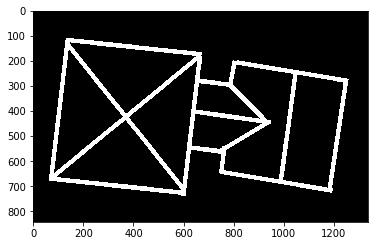

In [187]:
# Read in the image
image = cv2.imread('perfect_outline/roof8.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
image = util.invert(image)
plt.imshow(thresh, cmap='gray')
print('Shape:',image.shape)

In [188]:
inverted_gray_line = util.invert(image)
# plt.imshow(inverted_gray_line, cmap='gray')
print('Shape:',inverted_gray_line.shape)

Shape: (842, 1336)


Shape: (842, 1336)
The Number of Labeled Feature: 9


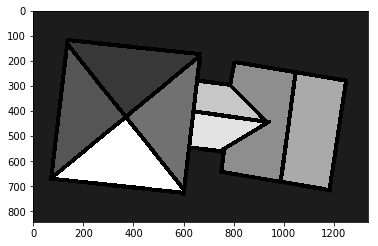

In [189]:
# Label the non-zero features in image 
labeled_array, num_features = ndimage.label(inverted_gray_line)
segmented_features = ndimage.find_objects(labeled_array)
# labeled_array = measure.label(inverted_gray_line)
labeled_array=np.float32(labeled_array)

plt.imshow(labeled_array*.2, cmap='gray')
print('Shape:',inverted_gray_line.shape)
print('The Number of Labeled Feature:', num_features)

## Extract feature shapes

In [190]:
count = 1
shape = []
for i in range(1,num_features+1):
    region = list(np.where(labeled_array == i))
    shape.append(region)
    print('Segmented Region', count,':', region)
    count += 1
print(len(shape))

Segmented Region 1 : [array([  0,   0,   0, ..., 841, 841, 841]), array([   0,    1,    2, ..., 1333, 1334, 1335])]
Segmented Region 2 : [array([128, 129, 129, ..., 411, 411, 412]), array([145, 145, 146, ..., 371, 372, 371])]
Segmented Region 3 : [array([155, 156, 156, ..., 646, 647, 647]), array([142, 142, 143, ...,  85,  83,  84])]
Segmented Region 4 : [array([201, 202, 202, ..., 691, 692, 693]), array([655, 654, 655, ..., 596, 596, 596])]
Segmented Region 5 : [array([216, 216, 216, ..., 672, 672, 672]), array([810, 811, 812, ..., 978, 979, 980])]
Segmented Region 6 : [array([257, 257, 257, ..., 704, 704, 705]), array([1054, 1055, 1056, ..., 1174, 1175, 1175])]
Segmented Region 7 : [array([290, 290, 290, ..., 431, 431, 431]), array([662, 663, 664, ..., 905, 906, 907])]
Segmented Region 8 : [array([412, 412, 413, ..., 551, 551, 551]), array([647, 648, 647, ..., 743, 744, 745])]
Segmented Region 9 : [array([436, 437, 437, ..., 716, 716, 716]), array([368, 367, 368, ..., 591, 592, 593])

In [191]:
shape_dict = {}
dilated = {}
kernel_d = np.ones((30,30),np.uint8)
fig = plt.figure()
areas = []
arc_num = []
part_centroid = {}

for item in range(0, len(shape)):
    vec = {}
    for i, j in enumerate(shape[item]):
        vec[i] = j
    shape_dict[item] = zip(vec[0], vec[1])
    arr = np.zeros(inverted_gray_line.shape)
    for i in shape_dict[item]:
        arr[i] = 1
    if item == 0:
        arr = util.invert(arr)
        outline = arr
    else: 
        dilated[item-1] = cv2.dilate(arr,kernel_d,iterations = 1) # enlarge the feature shape by dialtion
        major_axis, minor_axis, orientation, part_cx, part_cy, area, eig_value, eig_vector = image_moments(arr)
        areas.append(area)
        part_centroid[item-1] = part_cx, part_cy
    
#         plt.imshow(arr, cmap='gray')
#         plt.scatter(part_centroid[item-1][0], part_centroid[item-1][1])
#         plt.title('Feature Shape {}'.format(item)), plt.xticks([]), plt.yticks([])
#         plt.show()

for i in range(len(areas)):
    print('Feature shape {} occupies {}% of total area.'.format(i+1, areas[i]/np.sum(areas)*100))    

Feature shape 1 occupies 14.746155513195314% of total area.
Feature shape 2 occupies 13.606630606405046% of total area.
Feature shape 3 occupies 13.520386726403451% of total area.
Feature shape 4 occupies 16.609465597537408% of total area.
Feature shape 5 occupies 17.26115973693405% of total area.
Feature shape 6 occupies 4.5658394625458305% of total area.
Feature shape 7 occupies 5.349774217944919% of total area.
Feature shape 8 occupies 14.34058813903398% of total area.


## Image outline

In [192]:
# contours = measure.find_contours(outline, 0.8)

# black = np.zeros_like(outline)

# fig, ax = plt.subplots()
# ax.imshow(black, interpolation='nearest', cmap=plt.cm.gray)

# for n, contour in enumerate(contours):
#     a = ax.plot(contour[:, 1], contour[:, 0], color='white', linewidth=5)

In [193]:
kernel_e = np.ones((30,30),np.uint8)
outline = outline.astype(np.uint8)

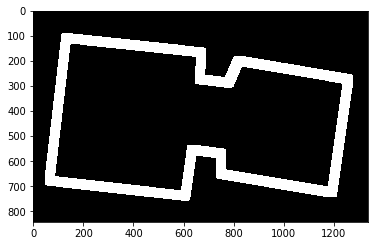

In [194]:
_, contours, _ = cv2.findContours(outline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
black = np.zeros_like(outline)
for cnt in contours:
    epsilon = 0.01*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)  # approximate corner points in polygon
    outline_d = cv2.drawContours(black, [approx], 0, (255, 255, 255), 7)
    outline_d = cv2.dilate(outline_d,kernel_e,iterations = 1)
    
plt.figure("Example 2")
plt.imshow(outline_d, cmap='gray')
plt.show()

## External edge

In [195]:
selected_area = []
h = []
for i in range(len(dilated)):
    summation = dilated[i] + outline_d/255
    
    if 2.0 in summation:
        overlap = np.zeros_like(summation)
        
        for ii in range(len(overlap)):
            selected_area = [iii for iii, x in enumerate(summation[ii]) if x == 2.0]
            overlap[ii][selected_area] = 1
            
#         plt.imshow(overlap, cmap='gray')
#         plt.show()

## Internal edge

In [200]:
combination = combinations(dilated,2)
select_area = []
contact_count = len(dilated)*[0]
contact_part = []
shape_overlap = {}

for i in combination:
    summation = dilated[i[0]] + dilated[i[1]]
    if 2.0 in summation:
        contact_count[i[0]] += 1
        contact_count[i[1]] += 1
        contact_part = [i[0], i[1]]
        print(contact_part)
        overlap = np.zeros_like(summation)
        for ii in range(len(overlap)):
            selected_area = [iii for iii,x in enumerate(summation[ii]) if x == 2]
            overlap[ii][selected_area] = 1
            
            
        end_points, angles, centroid, orientation, eig_value = endpoint_angle(overlap)
        
        d = (part_centroid[i[0]][0] - end_points[0])*(end_points[3]-end_points[1])- \
        (part_centroid[i[0]][1]-end_points[1])*(end_points[2]-end_points[0])
        
        # Show the contact line between faeture shapes
#         plt.imshow(overlap, cmap='gray')
#         plt.scatter(centroid[0], centroid[1])
#         plt.scatter(end_points[0], end_points[1])
#         plt.scatter(end_points[2], end_points[3])
#         plt.scatter(part_centroid[i[0]][0], part_centroid[i[0]][1])
#         plt.scatter(part_centroid[i[1]][0], part_centroid[i[1]][1])
        plt.show()
        print("Part {}  and part {} contact together".format(i[0]+1,i[1]+1))
        print("Two possible planes' angle are {} and {}".format(angles[0]*180/pi, angles[1]*180/pi))
        print("Line orientation angle is {}, and d value is {}".format((orientation*180/pi),d))
        print("eigenvalue x {} and eigenvalue y {}".format(eig_value[0], eig_value[1]))
             

[0, 1]
Part 1  and part 2 contact together
Two possible planes' angle are -128.8509101170993 and 51.14908988290072
Line orientation angle is -38.85091011709928, and d value is 46955.372528646665
eigenvalue x 49.504545753273305 and eigenvalue y 10910.032267188344
[0, 2]
Part 1  and part 3 contact together
Two possible planes' angle are -39.2057101482291 and 140.79428985177088
Line orientation angle is -39.2057101482291, and d value is -48459.9541193022
eigenvalue x 11471.959746318738 and eigenvalue y 49.467387986148424
[0, 7]
Part 1  and part 8 contact together
Two possible planes' angle are 1.3827823613428956 and -178.6172176386571
Line orientation angle is 1.3827823613428956, and d value is -5800.417108468886
eigenvalue x 82.46058368695331 and eigenvalue y 2.802477881884912
[1, 2]
Part 2  and part 3 contact together
Two possible planes' angle are -88.90169718066286 and 91.09830281933712
Line orientation angle is 1.0983028193371358, and d value is -5614.109370753324
eigenvalue x 1.9443

In [86]:
contact_count

[3, 2, 2, 3]